### Light python event model used to simulate Juster events
- liquidity providing risk estimation
- different market maker behaviur testing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.random import exponential, normal, uniform

from dynamics import calc_dynamics_by_freq
from coinbase_api import CoinbaseAPI
from plot import plot_dynamics_hists


sns.set_style("whitegrid")

In [2]:
import sys
sys.path.insert(0, '../../tests')
from event_model import EventModel

### Getting data to use as source of the price dynamics:

In [3]:
api = CoinbaseAPI()

pair = 'XTZ-USD'
event_durations = [3600, 21600, 86400]

dfs = {
    duration: api.get_history_prices(pair=pair, granularity=duration)
    for duration in event_durations
}

dynamics = {
    duration: calc_dynamics_by_freq(dfs[duration], f'{duration}S')
    for duration in event_durations
}

### Current data distribution:

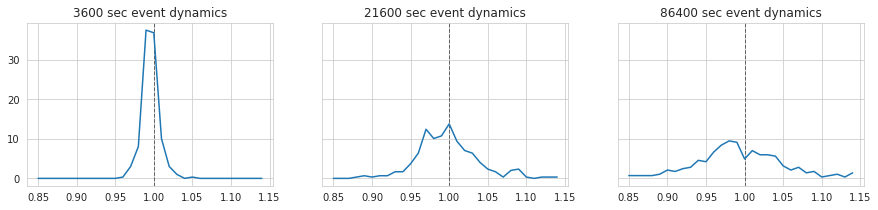

In [4]:
axes = plot_dynamics_hists(dynamics)

In [5]:
from random import random, randint, choice
from types import SimpleNamespace
from tqdm import tqdm

### Assumptions:

#### 1. Liquidity providers:
- there are two providers: one that adds liquidity in the event creation and second in random time during event (time selected using uniform distribution)
- first provider have expected market ratio that calculated as 

#### 2. Market expectation model:
- market ratio expectations are composed of different users expected ratio value
- users expected ratio value calculated before event creation and kept constant during event
- mean users expected ratio is equal to the real market ratio

#### 3. Users actions:
- user bets values are distributed exponentially
- bet pool is decided by difference between event pool and user expected pool
- MAYBE: user makes K bets proposals and selects one that leads event to the have the most close ratio to the user expectations (TODO: check this one, but I feel that it would change bet distribution)

## WIP
### TODO: process collected data: agregate, calculate stats
### TODO: save data (?)
### TODO: analyze data to answer questions
- maybe using dash or another BI? find a way to make it interactive, so it would be easy to calculate mean event results

In [6]:
def clipped_normal(mean, std, n=None, margin=0.0001):
    """ clips normal distribution between (0, 1) with small margin from both sides.
        used to generate noise to the market ratio
    """

    return np.clip(normal(mean, std, n), margin, 1-margin)

def ape(forecast, actual):
    """ Absolute percent error """

    return abs((forecast - actual)/actual)

Clipped normal visualization:

<AxesSubplot:>

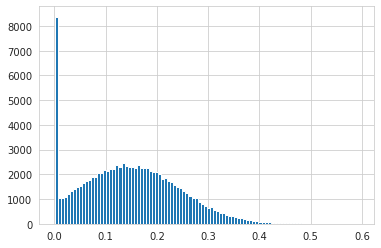

In [7]:
market_dynamics = dynamics[3600]
target_dynamics = 1.01

market_ratio = (market_dynamics >= target_dynamics).mean()
pd.Series(clipped_normal(market_ratio, 0.1, 100000)).hist(bins=100)

### TODO: there can be problems with event with analysing rates that too different from market ratio
- either need to change clipped_normal model
- either need to be very careful with events where target is not 0.5 and providers with big error rate
- but maybe it is OK, because if provider have big error: he suffers

In [8]:
def generate_params(market_dynamics, target_dynamics):

    # a_expected is the chance expectations that pool_a wins
    # calculating market ratio for the given params:
    market_expected_a = (market_dynamics >= target_dynamics).mean()

    provider_expected_a_deviation = 0.1

    # calculate provider expected ratio adding normal error to the market value:
    provider_expected_a = clipped_normal(
        market_expected_a,
        provider_expected_a_deviation)

    # this params affect liquidity size / bet size:
    providers_exp_scale = 100_000_000
    bet_value_exp_scale = 10_000_000

    # absolute percent error of provider are saved to be used in further analysis:
    provider_expected_a_ape = ape(provider_expected_a, market_expected_a)
    
    event_run_params = dict(
        # total betting length:
        ticks = 1000,

        # chance that one of the users will bet during the tick:
        bet_chance = choice([0.001, 0.01, 0.1, 0.5]),

        # amount of unique users in event:
        # NOTE: users count does not affect chances
        users_count = int(uniform(2, 100)),

        # Selecting actual dynamics as one of the market examples provided:
        actual_dynamics = choice(market_dynamics),

        target_dynamics = target_dynamics,

        fee = choice([0, 0.005, 0.01, 0.03, 0.05]),

        primary_provider_amount = exponential(providers_exp_scale),
        primary_provider_expected_a = provider_expected_a,
        primary_provider_expected_a_ape = provider_expected_a_ape,
        following_provider_amount = exponential(providers_exp_scale),

        # np.random.exponential param used to generate random value for bets
        bet_value_exp_scale = bet_value_exp_scale,

        # standard deviation param used to calculate each user marker expectation:
        bet_ratio_deviation = choice([0, 0.01, 0.05, 0.1, 0.2]),

        market_expected_a = market_expected_a,
    )

    return event_run_params

### TODO: include DAO profit fee somewhere

In [9]:
class User:
    def __init__(self, name, expected_a):
        self.name = name
        self.expected_a = expected_a

    def select_pool(self, event):
        return 'aboveEq' if self.expected_a > event.pool_a_expected() else 'below'


def test_user_model():
    # user expects 50:50 that price go where it want to go
    gambler = User('gambler', 0.5)

    # but there are event where he can win x10 if price > target (low a expectance):
    bearish_event = EventModel(pool_a=1, pool_b=9)
    assert gambler.select_pool(bearish_event) == 'aboveEq'

    # the opposite event with high expectance that price will be > target:
    bullish_event = EventModel(pool_a=9, pool_b=1)
    assert gambler.select_pool(bullish_event) == 'below'

    # market is equally expecting price movement:
    neutral_event = EventModel(pool_a=1, pool_b=1)

    # but there are insider who knows that market will drop soon:
    insider = User('insider', 0.1)
    assert insider.select_pool(neutral_event) == 'below'

    # or there are insider that is waiting for market boom:
    insider = User('insider', 0.9)
    assert insider.select_pool(neutral_event) == 'aboveEq'


test_user_model()

In [10]:
def run_random_event(**run_event_params):

    # TODO: decide is this good way to work with params?
    p = SimpleNamespace(**run_event_params)

    # creating users, each have unique market expectation:
    users = [User(
        name=f'user_{num}',
        expected_a=clipped_normal(
            p.market_expected_a,
            p.bet_ratio_deviation)
    ) for num in range(p.users_count)]

    primary_provider = 'primary_provider'
    following_provider = 'following_provider'

    winning_pool = 'aboveEq' if p.actual_dynamics >= p.target_dynamics else 'below'
    event = EventModel(
        fee=p.fee,
        winning_pool=winning_pool
    )

    event.provide_liquidity(
        user=primary_provider,
        amount=p.primary_provider_amount,
        pool_a=p.primary_provider_expected_a,
        pool_b=(1 - p.primary_provider_expected_a)
    )

    following_provider_entry_tick = randint(0, p.ticks)

    for tick in range(p.ticks):
        if p.bet_chance > random():
            user = choice(users)
            try:
                event.bet(
                    user=user.name,
                    amount=exponential(p.bet_value_exp_scale),
                    pool=user.select_pool(event),
                    time=tick/p.ticks
                )
            except Exception as e:
                import pdb; pdb.set_trace()

        if tick == following_provider_entry_tick:
            event.provide_liquidity(
                user=following_provider,
                amount=p.following_provider_amount
            )

    # TODO: do I need to analyze single users expectations and return them somehow?

    # TODO: do I need to calculate another meta params: bets count, mean bet value and others?
    # -- maybe improve EventModel to keep track this meta?

    # TODO: do I need to somehow agregate all users diffs and calculate stats?
    # -- looks like it is good to have some stat agregator after this event returned
    return event

### TODO: collect metadata during event about bets and other params

### Running generation:

In [14]:
market_dynamics = dynamics[3600]
target_dynamics = 1.00
iterations = 1000
results = []


for _ in tqdm(range(iterations)):
    params = generate_params(market_dynamics, target_dynamics)
    results.append({
        **params,
        **run_random_event(**params).to_dict()
    })

df = pd.json_normalize(results)

100%|██████████| 1000/1000 [00:02<00:00, 342.97it/s]


<AxesSubplot:>

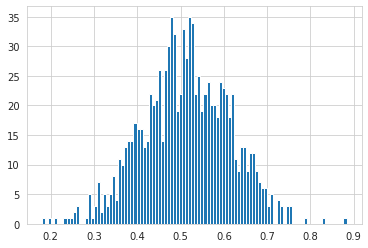

In [15]:
df.primary_provider_expected_a.hist(bins=100)

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ticks,1000.0,1.000000e+03,0.000000e+00,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
bet_chance,1000.0,1.558010e-01,2.071319e-01,1.000000e-03,1.000000e-03,1.000000e-02,5.000000e-01,5.000000e-01
users_count,1000.0,4.936200e+01,2.767466e+01,2.000000e+00,2.500000e+01,5.000000e+01,7.200000e+01,9.900000e+01
actual_dynamics,1000.0,1.001053e+00,1.081537e-02,9.693998e-01,9.939467e-01,1.000727e+00,1.006884e+00,1.050086e+00
target_dynamics,1000.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...
diffs.user_92,26.0,-3.555598e+06,3.207941e+07,-1.139610e+08,-1.415376e+07,1.861951e+06,1.098144e+07,5.137253e+07
diffs.user_95,15.0,-8.693192e+06,3.139137e+07,-6.978628e+07,-2.623818e+07,-8.674154e+06,4.461004e+06,4.925169e+07
diffs.user_96,7.0,-3.040344e+05,3.076202e+07,-5.131378e+07,-6.192515e+06,1.082447e+06,3.478224e+06,5.353167e+07
diffs.user_98,2.0,1.828576e+07,1.628711e+07,6.769032e+06,1.252739e+07,1.828576e+07,2.404412e+07,2.980248e+07


### TODO:
- make separate table with users ratio expecatations?

### Questions:
- how liquidity provider error affects his returns?
- does users market expectance variance affect provider returns?
- how liquidity provider profit depends from bets frequency / size?
- what difference between risks and profits of the primary and the folowing providers?
- what are expected profits for providers for providers with different fees amount?
    - mean, median, q1 and q99 profits
- what mean APY is generated by events and is it possible to make APY predictions using expected market activity params?